# Get TWSS data

In [ ]:
!mkdir -p /opt/data/
!wget -q https://github.com/tansaku/twss/archive/refs/heads/master.zip -O /opt/data/twss.zip
!unzip -q /opt/data/twss.zip -d /opt/data/

In [ ]:
!ls /opt/data/twss-master/data/

fml.txt		     svm_model.pk	  twssSample1.txt     usaquotes.txt.pk
fml.txt.pk	     test.pk		  twssSample2.txt     vocab.pk
README.txt	     tfln.onesent.txt	  twssstories.txt     vocab.txt
sentenceSample1.txt  tfln.onesent.txt.pk  twssstories.txt.pk
sentenceSample2.txt  train.pk		  usaquotes.txt


# Organize the files in 'pos' and 'neg' directory

In [ ]:
!mkdir -p /opt/data/pos/
!mkdir -p /opt/data/neg/
!cp /opt/data/twss-master/data/twssstories.txt /opt/data/pos/
!cp /opt/data/twss-master/data/fml.txt /opt/data/neg/
!cp /opt/data/twss-master/data/tfln.onesent.txt /opt/data/neg/
!cp /opt/data/twss-master/data/usaquotes.txt /opt/data/neg/
!ls /opt/data/pos/
!ls /opt/data/neg/

twssstories.txt
fml.txt  tfln.onesent.txt  usaquotes.txt


# Read data as samples and targets

In [ ]:
import os
import numpy as np

TWSS_DIR = '/opt/data/'

labels = []
texts = []

for label_type in ['neg', 'pos']:
  dir_name = os.path.join(TWSS_DIR, label_type)
  for fname in os.listdir(dir_name):
    if fname[-4:] == '.txt':
      f = open(os.path.join(dir_name, fname), encoding='latin1')
      for i, line in enumerate(f.readlines()):
        # Uncomment for balanced data
        if i >= 669 and label_type == 'neg':
          texts.append(line.rstrip())
          labels.append(2)
          continue
        texts.append(line.rstrip())
        if label_type == 'neg':
          labels.append(0)
        else:
          labels.append(1)
      f.close()

In [ ]:
print("Total Samples")
print(len(texts))
print(len(labels))

Total Samples
19863
19863


# Preprocessing with balanced training data

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

MAX_LEN = 100
MAX_WORDS = 20000

tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index

# print(sequences[:5])
# for s in sequences[:5]:
#   print(len(s))

# print([*word_index][:5])

all_data = pad_sequences(sequences, maxlen=MAX_LEN, padding='post')
all_labels = np.asarray(labels)

data_indices = [index for index, element in enumerate(all_labels) if element == 0 or element == 1]
extra_data_indices = [index for index, element in enumerate(all_labels) if element == 2]

data = all_data[np.asarray(data_indices)]
extra_data = all_data[np.asarray(extra_data_indices)]

labels = all_labels[np.asarray(data_indices)]
extra_labels = all_labels[np.asarray(extra_data_indices)]

# Change temp label '2' back to '0'
extra_labels = np.where(extra_labels == 2, 0, extra_labels)

# Shuffle data
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

# Train-test split
TEST_SPLIT = 0.9
N = round(len(data) * TEST_SPLIT)

train_X = data[:N]
train_Y = labels[:N]
test_X = data[N:]
test_Y = labels[N:]

# Verify the shape of the data
print(train_X.shape)
print(train_Y.shape)
print(test_X.shape)
print(test_Y.shape)

# print(data[:5])
# for s in data[:5]:
#   print(len(s))

# print(labels[:5])

(3631, 100)
(3631,)
(403, 100)
(403,)


In [ ]:
print("Neg training samples count:", np.count_nonzero(train_Y==0))
print("Pos training samples count:", np.count_nonzero(train_Y==1))

print("Neg test samples count:", np.count_nonzero(test_Y==0))
print("Pos test samples count:", np.count_nonzero(test_Y==1))

print("Number of tokens: ", len(word_index))

Neg training samples count: 1808
Pos training samples count: 1823
Neg test samples count: 199
Pos test samples count: 204
Number of tokens:  20758


# Preprocessing with imbalanced training data but balanced test and validation data

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

MAX_LEN = 100
MAX_WORDS = 15000

tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index

# print(sequences[:5])
# for s in sequences[:5]:
#   print(len(s))

# print([*word_index][:5])

all_data = pad_sequences(sequences, maxlen=MAX_LEN, padding='post')
all_labels = np.asarray(labels)

data_indices = [index for index, element in enumerate(all_labels) if element == 0 or element == 1]
extra_data_indices = [index for index, element in enumerate(all_labels) if element == 2]

data = all_data[np.asarray(data_indices)]
extra_data = all_data[np.asarray(extra_data_indices)]
print("Extra Data Length:", extra_data.shape)

labels = all_labels[np.asarray(data_indices)]
extra_labels = all_labels[np.asarray(extra_data_indices)]
print("Extra Data Labels Length:", extra_labels.shape)

# Change temp label '2' back to '0'
extra_labels = np.where(extra_labels == 2, 0, extra_labels)

# Shuffle data
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

# Train-test split
TRAIN_SPLIT = 0.9
N = round(TRAIN_SPLIT * data.shape[0])

train_X = data[:N, :]
train_Y = labels[:N]
test_X = data[N:, :]
test_Y = labels[N:]

# Pull the last 10% as a validation set
N = round(TRAIN_SPLIT * train_X.shape[0])
val_X = train_X[N:, :]
val_Y = train_Y[N:]
train_X = train_X[:N, :]
train_Y = train_Y[:N]

# Verify the shape of the data
print(train_X.shape)
print(train_Y.shape)
print(test_X.shape)
print(test_Y.shape)
print(val_X.shape)
print(val_Y.shape)

train_X = np.concatenate((train_X, extra_data))
train_Y = np.concatenate((train_Y, extra_labels))

print(train_X.shape)
print(train_Y.shape)

# print(data[:5])
# for s in data[:5]:
#   print(len(s))

# print(labels[:5])

Extra Data Length: (15829, 100)
Extra Data Labels Length: (15829,)
(3268, 100)
(3268,)
(403, 100)
(403,)
(363, 100)
(363,)
(19097, 100)
(19097,)


In [ ]:
print("Neg training samples count:", np.count_nonzero(train_Y==0))
print("Pos training samples count:", np.count_nonzero(train_Y==1))

print("Neg test samples count:", np.count_nonzero(test_Y==0))
print("Pos test samples count:", np.count_nonzero(test_Y==1))

print("Neg val samples count:", np.count_nonzero(val_Y ==0))
print("Pos val samples count:", np.count_nonzero(val_Y==1))

print("Number of tokens: ", len(word_index))

Neg training samples count: 17451
Pos training samples count: 1646
Neg test samples count: 202
Pos test samples count: 201
Neg val samples count: 183
Pos val samples count: 180
Number of tokens:  20758


# Preprocessing with imbalanced training data

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

MAX_LEN = 100
MAX_WORDS = 20000

tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index

# print(sequences[:5])
# for s in sequences[:5]:
#   print(len(s))

# print([*word_index][:5])

data = pad_sequences(sequences, maxlen=MAX_LEN, padding='post')
labels = np.asarray(labels)

# Shuffle data
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

# Train-test split
TEST_SPLIT = 0.9
N = round(len(data) * TEST_SPLIT)

train_X = data[:N]
train_Y = labels[:N]
test_X = data[N:]
test_Y = labels[N:]

# Verify the shape of the data
print(train_X.shape)
print(train_Y.shape)
print(test_X.shape)
print(test_Y.shape)

# print(data[:5])
# for s in data[:5]:
#   print(len(s))

# print(labels[:5])

(17877, 100)
(17877,)
(1986, 100)
(1986,)


In [ ]:
print("Neg training samples count:", np.count_nonzero(train_Y==0))
print("Pos training samples count:", np.count_nonzero(train_Y==1))

print("Neg test samples count:", np.count_nonzero(test_Y==0))
print("Pos test samples count:", np.count_nonzero(test_Y==1))

print("Number of tokens: ", len(word_index))

Neg training samples count: 16051
Pos training samples count: 1826
Neg test samples count: 1785
Pos test samples count: 201
Number of tokens:  20758


# Setup GloVe Embeddings

In [ ]:
# Get the GloVe embeddings
!mkdir -p /opt/data/
!wget http://nlp.stanford.edu/data/glove.6B.zip -O /opt/data/glove.6B.zip
!unzip /opt/data/glove.6B.zip -d /opt/data/

--2021-04-16 19:48:01--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-04-16 19:48:01--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-04-16 19:48:01--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘/opt/data/glove.6B.zip

In [ ]:
!ls /opt/data/

glove.6B.100d.txt  glove.6B.300d.txt  glove.6B.zip  pos		 twss.zip
glove.6B.200d.txt  glove.6B.50d.txt   neg	    twss-master


In [ ]:
import os

BASE_DIR = '/opt/data/'
EMBEDDING_DIM = 300
GLOVE_DIR = os.path.join(BASE_DIR, f'glove.6B.{EMBEDDING_DIM}d.txt')

embeddings_index = {}
with open(GLOVE_DIR) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
# embeddings_index['apple']

# Encode TWSS words into embedding vectors

In [ ]:
# Use all the all the words in the training data
MAX_WORDS = len(word_index)

In [ ]:
embedding_matrix = np.zeros((MAX_WORDS, EMBEDDING_DIM))
for word, i in word_index.items():
  if i < MAX_WORDS:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

embedding_matrix.shape

(20758, 300)

# Define helper functions

In [ ]:
def print_results(results, name):
  print(f"\n{name} Results")
  print('-' * (len(name) + 1 + len("Results")))
  print(f"Loss: {results[0]*100:.2f}%")
  print(f"Precision: {results[1]*100:.2f}%")
  print(f"Recall: {results[2]*100:.2f}%")
  print(f"AUC: {results[3]*100:.2f}%")
  print(f"Accuracy: {results[4]*100:.2f}%")

# Train the model

In [ ]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding, Dropout
from keras.metrics import Precision, Recall, BinaryAccuracy, AUC
from keras.layers import LSTM, GRU, Bidirectional, Masking
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

model = Sequential()
# model.add(Embedding(MAX_WORDS, EMBEDDING_DIM, mask_zero=False, input_length=MAX_LEN))
model.add(Embedding(MAX_WORDS, EMBEDDING_DIM, mask_zero=True))
# model.add(Masking(mask_value=0, input_shape=(MAX_LEN, EMBEDDING_DIM)))
model.add(GRU(128, dropout=0.2))
# model.add(Bidirectional(GRU(128, dropout=0.5)))
# model.add(Flatten())
# model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False
model.summary()
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=[Precision(), Recall(), AUC(), BinaryAccuracy()])
es = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=3)

# For imbalanced training data but balanced test and validation data
# history = model.fit(train_X, train_Y, epochs=10, batch_size=32, validation_data=(val_X, val_Y))

# Validation split
# history = model.fit(train_X, train_Y, epochs=100, batch_size=32,  callbacks=[es], validation_split=0.1)
# history = model.fit(train_X, train_Y, epochs=10, batch_size=32, validation_split=0.1)

# No validation split
# history = model.fit(train_X, train_Y, epochs=100, batch_size=32,  callbacks=[es])
history = model.fit(train_X, train_Y, epochs=10, batch_size=32)

# print(model.predict(data[:10,:]))
# print(labels[:10])
results = model.evaluate(test_X, test_Y)
print_results(results, "Test")

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_34 (Embedding)     (None, None, 300)         6227400   
_________________________________________________________________
gru_33 (GRU)                 (None, 128)               165120    
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 129       
Total params: 6,392,649
Trainable params: 165,249
Non-trainable params: 6,227,400
_________________________________________________________________
Epoch 1/10
114/114 [==============================] - 6s 14ms/step - loss: 0.4851 - precision_31: 0.7145 - recall_31: 0.8085 - auc_31: 0.8175 - binary_accuracy: 0.7331
Epoch 2/10
114/114 [==============================] - 2s 13ms/step - loss: 0.1634 - precision_31: 0.9323 - recall_31: 0.9520 - auc_31: 0.9836 - binary_accuracy: 0.9411
Epoch 3/10
114/114 [===========

In [ ]:
print(history.history.keys())

# Visualize test evaluation

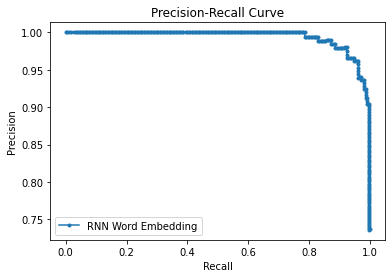

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

preds_Y = model.predict(test_X)

precision, recall, thresholds = precision_recall_curve(test_Y, preds_Y)

plt.plot(recall, precision, marker='.', label='RNN Word Embedding')
plt.title(f'Precision-Recall Curve')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
plt.savefig("best_model_pr-rc.png", dpi=256, format='png')
# show the plot
plt.show()

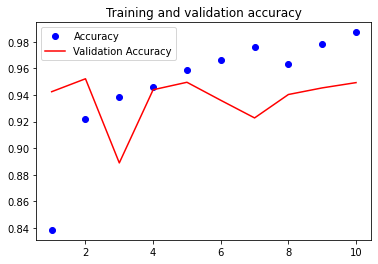

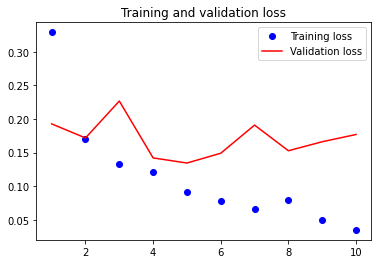

In [ ]:
import matplotlib.pyplot as plt

hist_keys = list(history.history.keys())

def plot_acc_loss(history):
  history_dict = history.history

  acc = history_dict[hist_keys[1]]
  val_acc = history_dict[hist_keys[6]]
  loss = history_dict['loss']
  val_loss = history_dict['val_loss']

  epochs = range(1, len(acc) + 1)

  plt.plot(epochs, acc, 'bo', label=f'Accuracy')
  plt.plot(epochs, val_acc, 'r', label=f'Validation Accuracy')
  plt.title(f'Training and validation accuracy')
  plt.legend()

  # plt.savefig("best_model_acc.png", dpi=144, format='png')
  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  # plt.savefig("best_model_loss.png", dpi=144, format='png')
  plt.show()

plot_acc_loss(history)

In [ ]:
test_X.shape

# Save the model

In [ ]:
model.save('best_twss_model.h5')

# Load the model

In [ ]:
from keras import models
model = models.load_model('best_twss_model.h5')

# Test the model

In [ ]:
from collections import OrderedDict

sample_twss = OrderedDict({
    "Wow! I cannot believe it. This is much bigger than I thought it would be.": 1,
    "He’s under a lot of pressure, which builds up until he’s ready to explode. It’s my job to release that pressure.": 1,
    "Please don't make it harder than it has to be.": 1,
    "I was trying all night yesterday, but I couldn't get it in.": 1,
    "I fear the people will not quietly submit to those restraints which are necessary for the peace and security of the community.": 0,
    "I am going to go home tonight and find a place to put this.": 1,
    "I will be completely honest with you, I wanted this so bad I could taste it.": 1,
    "Thank You! This is a true honour and I'm glad that I came.": 1,
    "I love eating apples, bananas and mango.": 0,
    "I love eating bananas.": 1,
    "I like banana trees.": 0,
    "I love reading books.": 0,
    "I spilled water all over the floor.": 0,
    "You really think you can go all day long.": 1,
    "Well, you always left me satisfied and smiling.": 1,
    "Well, you always left me angry.": 0,
    "Why did you get it so big?": 1,
    "Why did you get it so late?": 0,
    "Does the skin look red and swollen?": 1,
    "That thing looks red and swollen": 1,
    "That thing looks long, red and swollen.": 1,
    "You already did me!": 1,
    "I can't stay on top of you 24/7.": 1,
    "You don't need to be banging that hard.": 1,
    "You don't need to bang that hard.": 1,
    "Don't bang on the door that hard.": 0,
    "Long, hard and fast.": 1,
    "Can you grab my banana for a while?": 1
})

sequences = tokenizer.texts_to_sequences(list(sample_twss.keys()))
twss_data = pad_sequences(sequences, maxlen=MAX_LEN)

sample_results = model.evaluate(twss_data, np.array(list(sample_twss.values())))
print_results(sample_results, "Sample Test")

predictions = model.predict(twss_data)

for i, sample in enumerate(sample_twss):
  print(f'\n{sample} => {predictions[i][0]*100:.2f}%')

1/1 [==============================] - 0s 36ms/step - loss: 1.2751 - precision_31: 0.7917 - recall_31: 0.9500 - auc_31: 0.6188 - binary_accuracy: 0.7857

Sample Test Results
-------------------
Loss: 127.51%
Precision: 79.17%
Recall: 95.00%
AUC: 61.88%
Accuracy: 78.57%

Wow! I cannot believe it. This is much bigger than I thought it would be. => 99.99%

He’s under a lot of pressure, which builds up until he’s ready to explode. It’s my job to release that pressure. => 99.99%

Please don't make it harder than it has to be. => 99.91%

I was trying all night yesterday, but I couldn't get it in. => 99.71%

I fear the people will not quietly submit to those restraints which are necessary for the peace and security of the community. => 0.00%

I am going to go home tonight and find a place to put this. => 88.43%

I will be completely honest with you, I wanted this so bad I could taste it. => 98.74%

Thank You! This is a true honour and I'm glad that I came. => 0.70%

I love eating apples, bana

# Evaluate extra data (Optional)

In [ ]:
print(f"Extra Data Length: {len(extra_data)}", end='\n\n')
print(model.evaluate(extra_data, extra_labels))

In [ ]:
model.save('test_model.h5')